<a href="https://colab.research.google.com/github/Chancylin/Deep_Learning_Notes/blob/master/Copy_of_lstm_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character-level recurrent sequence-to-sequence model

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2017/09/29<br>
**Last modified:** 2020/04/26<br>
**Description:** Character-level recurrent sequence-to-sequence model.

## Introduction

This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.


## Setup


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


## Download the data


In [3]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip


['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

In [4]:
! ls
! pwd

_about.txt  fra-eng.zip  fra.txt  sample_data
/content


## Configuration


In [0]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"


## Prepare the data


In [0]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

In [7]:
print(len(lines))
print(lines[0])
lines[1]

175624
Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)


'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)'

In [8]:

for line in lines[: min(num_samples, len(lines) - 1)]:
    # split by tab to get the English and French for every input sentence
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
# lcx: tokens are the unique charactres
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
# lcx: get the max length of the sentence 
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)



Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [0]:
# lcx: build the dictionary from enumerate, very effective coding
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [10]:
print(target_token_index[" "])
print(target_token_index["\t"])
print(target_token_index["\n"])

2
0
1


In [0]:
# lcx: number of instances, max_seq_length, number_tokens

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # lcx: this is actually an one-hot-encoding for the sentence 
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [12]:
decoder_input_data[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [13]:
decoder_target_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [14]:
# lcx: check the time step shift
for i in [0,1,2]:
  print("="*10, "time step "+ str(i), "="*10)
  print("deconder input")
  print(decoder_input_data[0][i])
  print("deconder target")
  print(decoder_target_data[0][i])

========== time step 0 ==========
deconder input
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
deconder target
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
========== time step 1 ==========
deconder input
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
deconder target
[0. 0. 0. 0. 0. 0.

## Build the model


In [0]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm[0][1]                   

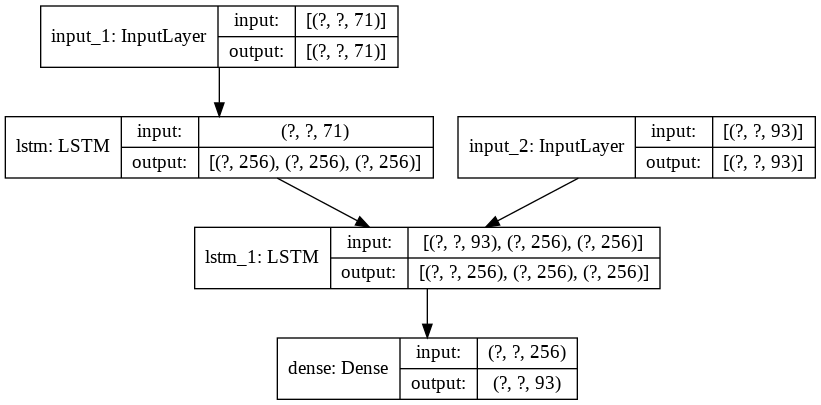

In [17]:
tf.keras.utils.plot_model(model, to_file="seq2seq_model.png", show_shapes=True)

## Train the model


In [18]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")


Epoch 1/100
125/125 [==============================] - 2s 18ms/step - loss: 1.1712 - accuracy: 0.7248 - val_loss: 1.0656 - val_accuracy: 0.7093
Epoch 2/100
125/125 [==============================] - 2s 13ms/step - loss: 0.8472 - accuracy: 0.7713 - val_loss: 0.8379 - val_accuracy: 0.7661
Epoch 3/100
125/125 [==============================] - 2s 13ms/step - loss: 0.6771 - accuracy: 0.8079 - val_loss: 0.7212 - val_accuracy: 0.7887
Epoch 4/100
125/125 [==============================] - 2s 13ms/step - loss: 0.5956 - accuracy: 0.8268 - val_loss: 0.6576 - val_accuracy: 0.8071
Epoch 5/100
125/125 [==============================] - 2s 13ms/step - loss: 0.5468 - accuracy: 0.8400 - val_loss: 0.6100 - val_accuracy: 0.8221
Epoch 6/100
125/125 [==============================] - 2s 13ms/step - loss: 0.5110 - accuracy: 0.8501 - val_loss: 0.5808 - val_accuracy: 0.8289
Epoch 7/100
125/125 [==============================] - 2s 13ms/step - loss: 0.4824 - accuracy: 0.8577 - val_loss: 0.5608 - val_accuracy:

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [21]:
model.layers

## Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [0]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
# lcx: why can we just assemble keras model in this way, the "encoder_states" is
# the outputs of the model?
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        # lcx: why "-1" for output_tokens[0, -1, :]
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence



You can now generate decoded sentences as such:


In [22]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Who?
Decoded sentence: Qui est-ce ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Hello!
Decoded sentence: Salut